## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(1):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.04it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_0"])
layer_hs_array.shape

(10000, 267264)

## Layer 0 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
# X_train, y_train, X_test, y_test = [], [], [], []
# for i in range(10):
#     X_train.extend(dim_reduced_vecs[i * 1000 : (i * 1000) + 800]) # [0:800] [1000:1800] etc.
#     y_train.extend(prompt_ids[i * 1000 : (i * 1000) + 800])
    
#     X_test.extend(dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]) # [800:1000] [1800:2000] etc.
#     y_test.extend(prompt_ids[(i * 1000) + 800 : (i + 1) * 1000])

In [11]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

In [12]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [13]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 10
  Iteration 19 (0.54 s, search 0.29 s): objective=1149.53 imbalance=1.356 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (1.07 s, search 0.57 s): objective=1144.37 imbalance=1.126 nsplit=0       
Outer iteration 2 / 10
  Iteration 19 (1.60 s, search 0.84 s): objective=1135.56 imbalance=1.032 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (2.12 s, search 1.12 s): objective=1144.57 imbalance=1.208 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (2.63 s, search 1.39 s): objective=1143.15 imbalance=1.540 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (3.15 s, search 1.66 s): objective=1138.35 imbalance=1.221 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (3.67 s, search 1.93 s): objective=1148.22 imbalance=1.142 nsplit=0       
Outer iteration 7 / 10


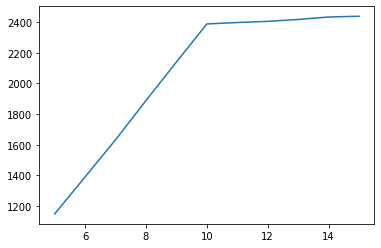

In [15]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

#k_vals[np.argmax(wccs)]

In [16]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.04 s
Outer iteration 0 / 10
  Iteration 19 (1.03 s, search 0.55 s): objective=2356.07 imbalance=1.349 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (2.06 s, search 1.09 s): objective=2380.2 imbalance=1.239 nsplit=0        
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (3.08 s, search 1.63 s): objective=2387.8 imbalance=1.315 nsplit=0        
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (4.14 s, search 2.18 s): objective=2383.07 imbalance=1.321 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (5.18 s, search 2.73 s): objective=2367.91 imbalance=1.571 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (6.21 s, search 3.27 s): objective=2344.83 imbalance=1.202 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (7.23 s, search 3.82 s): objective=2381.96 imbalance=1.340 nsplit=

2387.801025390625

In [17]:
kmeans.centroids #cluster centers

array([[ 0.01507488,  0.00552363,  0.00066397, ...,  0.00624804,
        -0.0167891 , -0.01160532],
       [-0.00132467,  0.01328805, -0.00308383, ..., -0.00447619,
        -0.00707773, -0.00483568],
       [ 0.02875751,  0.02307365, -0.00160075, ...,  0.00028084,
        -0.00994218, -0.01013203],
       ...,
       [ 0.00789195,  0.02493598, -0.01209482, ..., -0.00511604,
        -0.0058887 , -0.00464228],
       [ 0.01009194, -0.00219742,  0.00997888, ..., -0.00809156,
        -0.00632714, -0.01846112],
       [ 0.02085572,  0.01073467,  0.0112203 , ..., -0.01463787,
        -0.0069159 , -0.0064244 ]], dtype=float32)

In [18]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000001
0.9999999
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
1.0
0.99999994
1.0000002


In [19]:
kmeans.obj #inertia at each iteration

array([ 792.01263428, 2258.98925781, 2328.08642578, 2344.00463867,
       2350.15209961, 2352.42871094, 2354.32397461, 2355.40234375,
       2355.65063477, 2355.81616211, 2355.93920898, 2355.97436523,
       2356.00170898, 2356.01733398, 2356.03100586, 2356.03833008,
       2356.05932617, 2356.06713867, 2356.06713867, 2356.06713867,
        834.53125   , 2241.22290039, 2333.04516602, 2346.31323242,
       2356.37231445, 2366.66796875, 2374.36987305, 2377.53588867,
       2378.94628906, 2379.40649414, 2379.57006836, 2379.65722656,
       2379.73266602, 2379.79833984, 2379.86889648, 2379.91088867,
       2380.00488281, 2380.0847168 , 2380.1496582 , 2380.20068359,
        847.32299805, 2247.42797852, 2323.24780273, 2362.19555664,
       2372.86279297, 2379.50073242, 2383.37695312, 2386.53710938,
       2387.53857422, 2387.63598633, 2387.67260742, 2387.69946289,
       2387.73168945, 2387.7487793 , 2387.76586914, 2387.77026367,
       2387.77563477, 2387.78686523, 2387.80395508, 2387.80102

In [20]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [21]:
pd.Series(classifications_train).value_counts()

4    1714
3    1279
6    1139
9    1063
1     659
0     598
5     467
7     467
2     333
8     281
dtype: int64

In [22]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[3, 5, 10, 6, 4, 5, 9, 10, 2, 8]

In [23]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [24]:
centroid_to_label

{0: 3, 1: 5, 2: 10, 3: 6, 4: 4, 5: 5, 6: 9, 7: 10, 8: 2, 9: 8}

In [25]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 9,  9,  9, ..., 10, 10, 10])

In [26]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.0
Prompt 2 Accuracy:  0.285
Prompt 3 Accuracy:  0.7475
Prompt 4 Accuracy:  0.355
Prompt 5 Accuracy:  0.945
Prompt 6 Accuracy:  0.47375
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.495
Prompt 9 Accuracy:  0.22875
Prompt 10 Accuracy:  1.0


In [27]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.453


## Perform Inference on Test Set & Collect Test Accuracy

In [28]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [29]:
pd.Series(classifications_test).value_counts()

4    423
3    324
6    310
9    262
1    158
0    135
7    123
5    122
2     77
8     66
dtype: int64

In [30]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 8,  4,  9, ..., 10, 10, 10])

In [31]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.0
Prompt 2 Accuracy:  0.3
Prompt 3 Accuracy:  0.675
Prompt 4 Accuracy:  0.35
Prompt 5 Accuracy:  0.94
Prompt 6 Accuracy:  0.44
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.49
Prompt 9 Accuracy:  0.255
Prompt 10 Accuracy:  1.0


In [32]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.445


## Confusion Matrix of Results

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

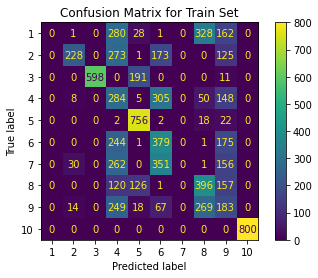

In [34]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

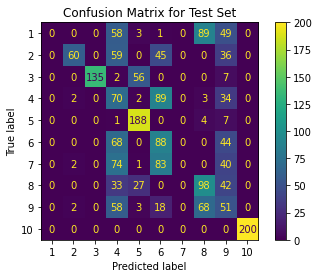

In [35]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()